<a href="https://colab.research.google.com/github/raulbs7/Machine-Learning-Techniques-Project/blob/master/Dengue_Supervised_Project/2_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Baseline

At this part, the goal will be to investigate what type of regression algorithm give us better results to, after that, make an optimization of his parameters.


## 2.1  Initialization

First of all, it is going to be imported all the Python libraries normally used in data science. Also, it will be imported the datasets.

In [1]:
# data load and manipulation
from google.colab import files
from google.colab import drive
import io
# dataframes library
import pandas as pd
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# basic operations
import numpy as np
# cross validation
from sklearn.model_selection import KFold
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression
# regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
# metrics 
from sklearn.metrics import mean_absolute_error
from scipy.stats.stats import pearsonr
# normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# outliers
from scipy import stats

This function is used por obtain a dataframe from a csv file, in which we can determine the columns we want.

In [ ]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

Importing the preprocessed train and test dataset.

In [ ]:
train = upload_files([])
train.head()

Saving processed_train.csv to processed_train.csv
User uploaded file "processed_train.csv" with length 291364 bytes


,city,year,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,month
0,0,1990,18,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,4
1,0,1990,19,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,5
2,0,1990,20,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,5
3,0,1990,21,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,5
4,0,1990,22,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,5


In [ ]:
test = upload_files([])
test.head()

Saving processed_test.csv to processed_test.csv
User uploaded file "processed_test.csv" with length 82243 bytes


,city,year,weekofyear,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
0,0,2008,18,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,4
1,0,2008,19,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,5
2,0,2008,20,-0.016133,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,5
3,0,2008,21,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,5
4,0,2008,22,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,5


## 2.2 Analysis of data

The train data is already preprocessed and there is not any null value. 

In [ ]:
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

In [ ]:
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

This dataset has many variables, so it is recommended, in order to train a model with less time, the reduction of some features can improve the model's performance, due to the addition of noise that can perjudicate the predictions. In each model the extraction of features is different because each of them has a different criteria with this immportance.

The goal will be executed with cross validation to see the estimated performance. After that is taken an sample of this models to extract the most important features, in order to remove noise and improve training. 

---
Before this project, another investigation was done interpreting the data, and applying to it unsupervised learning techniques, which provides very useful information.
By doing hierarchical clustering to this dataset, it was seen that there are some important variables that could represent each family of clusters:

* ``reanalysis_relative_humidity_percent``
* ``reanalysis_air_temp_k``
* ``station_avg_temp_c``
* ``reanalysis_precip_amt_kg_per_m2``
* ``reanalysis_tdtr_k``

Also, there is going to be added other important features such as ``weekofyear`` and the preprocessed columns ``city`` and ``month``, very determinant because they are differents cities with independent data. This data, as equal as ``year``, are going to be categorical, so the treatment must be different with the other variables.

Regarding the correlations between the continuos train variables and the labels, they could be represented in this heatmap.

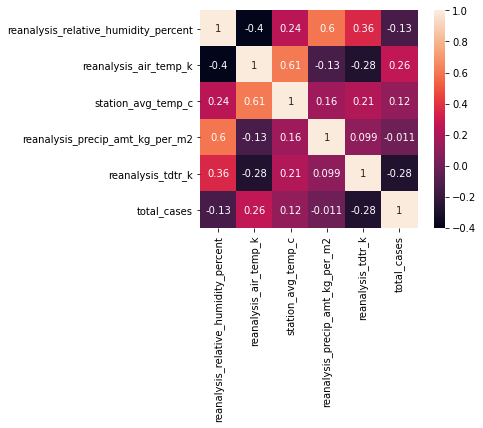

In [ ]:
corr_mtx = train[['reanalysis_relative_humidity_percent', 'reanalysis_air_temp_k', 
                  'station_avg_temp_c', 'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_tdtr_k', 'total_cases']].corr()
sns.heatmap(corr_mtx , square = True, annot=True)

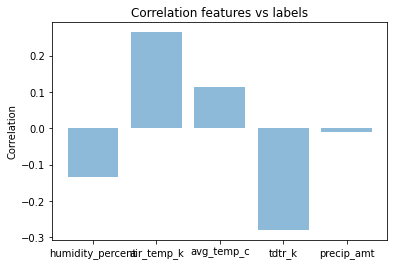

[-0.13420298738521033,
 0.264263466920149,
 0.11504179216456215,
 -0.27995710003301444,
 -0.011081416126311935]

In [ ]:
corr = [pearsonr(train['reanalysis_relative_humidity_percent'], train['total_cases'])[0], 
        pearsonr(train['reanalysis_air_temp_k'], train['total_cases'])[0], 
        pearsonr(train['station_avg_temp_c'], train['total_cases'])[0],
        pearsonr(train['reanalysis_tdtr_k'], train['total_cases'])[0],
        pearsonr(train['reanalysis_precip_amt_kg_per_m2'], train['total_cases'])[0]]

features= ('humidity_percent', 'air_temp_k', 'avg_temp_c', 'tdtr_k', 'precip_amt')
y_pos = np.arange(len(features))

plt.bar(y_pos, corr, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Correlation')
plt.title('Correlation features vs labels')

plt.show()

corr

The graph and the pearson coefficient between the continuos variables and the labels, show that there isn't a very strong linear relationship between those features. 

---
Also the relationship between this features can be represented like this.

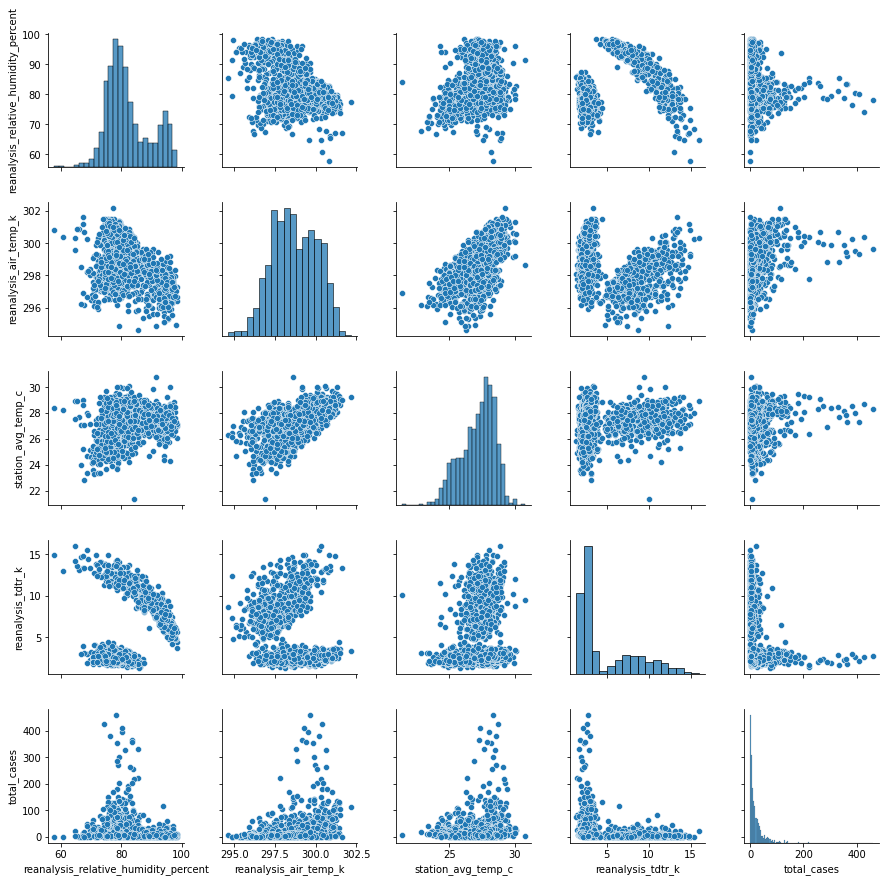

In [ ]:
sns.pairplot(train[['reanalysis_relative_humidity_percent', 
                'reanalysis_air_temp_k', 'station_avg_temp_c', 'reanalysis_tdtr_k', 'total_cases']])

If the evolution of total cases along the time is plot, it is obtained this.

In [ ]:
sj_train_labels = train[train['city']==0]['total_cases']
iq_train_labels = train[train['city']==1]['total_cases']

In [ ]:
sj_rng = pd.date_range('30/04/1990', periods = len(sj_train_labels), freq = 'W')
iq_rng = pd.date_range('26/06/2000', periods = len(iq_train_labels), freq = 'W')

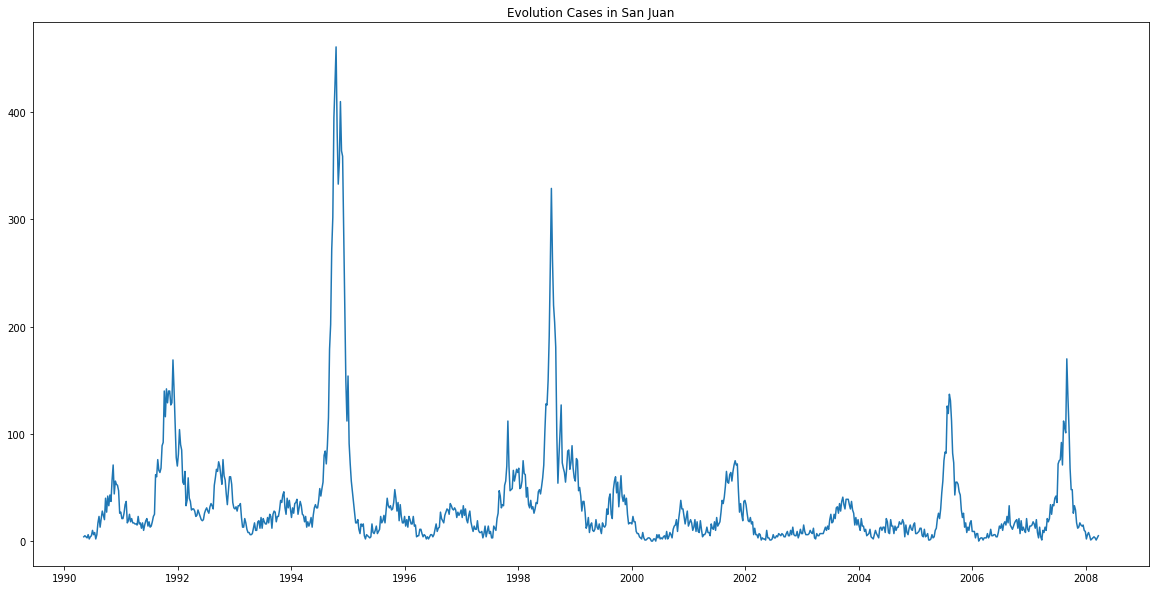

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(sj_rng, sj_train_labels)
plt.title('Evolution Cases in San Juan')
plt.show()

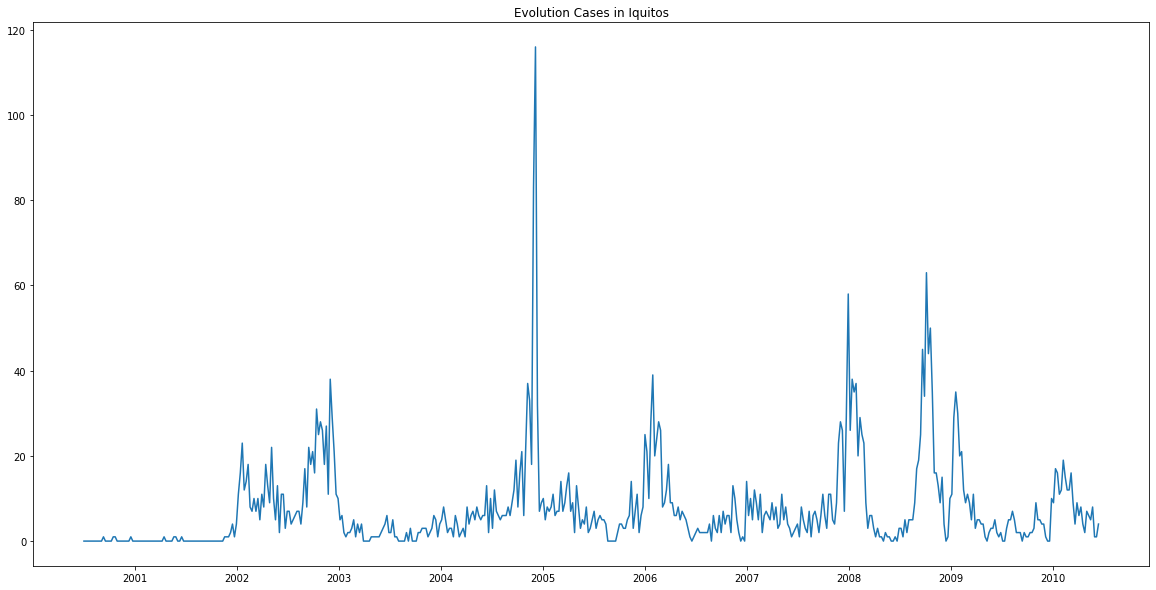

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(iq_rng, iq_train_labels)
plt.title('Evolution Cases in Iquitos')
plt.show()

It is important to take in count, that there could be some rows with values not very common, which can distorsionate the values of the predictions and the model. The name of this values is called outliers, and it could be useful to elimiinate them in order to have data more uniform. This is done by taking only entries that enter in the interval of 5 of z-score, because this value represents the number of standard deviations that the entry has. So all of values out of this interval, they are considered outliers.

In [ ]:
train.shape

(1454, 24)

In [ ]:
train = train[(np.abs(stats.zscore(train.drop(['year','weekofyear','total_cases'],axis=1))) < 5).all(axis=1)]

In [ ]:
train.shape

(1439, 24)

In [ ]:
train = pd.get_dummies(train, columns=['month'])
test = pd.get_dummies(test, columns=['month'])

The shape of this data is:

In [ ]:
print('Shape of selected features for train: ', train.shape)
print('Shape of selected features for test: ', test.shape)
print('Shape of labels for train: ', train['total_cases'].shape)

Shape of selected features for train:  (1439, 35)
Shape of selected features for test:  (416, 34)
Shape of labels for train:  (1439,)


## 2.3 Models 

In order to find what model is the best that fits the data, it is necessary to prove some algorithms, to see which are the ones giving less error. To have more accurate coefficients of error, cross validation will be used.

---

It was proved to have different models for each city, but the dataset of **Iquitos** generate predictions so exaggerated.

In [ ]:
cv = KFold(n_splits = 10, shuffle = False)

### 2.3.1 Random Forests


Random Forests will be an algorithm that could give a good result and a good performance.

In [ ]:
X_train = train.drop(['total_cases'], axis=1)
X_test = test
y_train = train['total_cases']

In [ ]:
fold_mae = []

for train_fold, test_fold in cv.split(X_train):
  # Random division of the train set to do cross validation
  f_train_X = X_train.iloc[train_fold]
  f_test_X = X_train.iloc[test_fold]
  f_train_y = y_train.iloc[train_fold]
  f_test_y = y_train.iloc[test_fold]
  # FIT THE MODEL
  f_model = RandomForestRegressor().fit(f_train_X, f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X)
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Random Forest implementation: ', forest_mae)

Estimated MAE of Random Forest implementation:  20.875106254856256


In [ ]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Once created the model with all features, the best features with more importance are going to be selected.

In [ ]:
feat_forest = pd.DataFrame({'Attributes': X_train.columns,
                                'Random Forest': forest.feature_importances_})
feat_forest.sort_values('Random Forest', ascending=False).head(15)

,Attributes,Random Forest
1,year,0.233656
5,ndvi_sw,0.204337
2,weekofyear,0.154997
4,ndvi_se,0.058118
7,reanalysis_air_temp_k,0.045169
9,reanalysis_dew_point_temp_k,0.031350
12,reanalysis_precip_amt_kg_per_m2,0.030110
21,station_precip_mm,0.022677
19,station_max_temp_c,0.022633
3,ndvi_nw,0.019278


The first 15 features with the best importance are going to be selected.

In [ ]:
selected_feat_forest = ['year', 'weekofyear', 'ndvi_sw', 'reanalysis_max_air_temp_k', 
                        'reanalysis_specific_humidity_g_per_kg', 'ndvi_se', 
                        'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'station_max_temp_c',
                        'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'ndvi_nw']

In [ ]:
X_train = X_train[selected_feat_forest]
X_test = X_test[selected_feat_forest]

In [ ]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### 2.3.2 Linear Regression

Linear Regression could be also useful for data with linear relationship.

In [ ]:
X_train = train.drop(['total_cases'], axis=1)
X_test = test
y_train = train['total_cases']

In [ ]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)

In [ ]:
fold_mae = []

for train_fold, test_fold in cv.split(X_train):
  # Random division of the train set to do cross validation
  f_train_X = X_train.iloc[train_fold]
  f_test_X = X_train.iloc[test_fold]
  f_train_y = y_train.iloc[train_fold]
  f_test_y = y_train.iloc[test_fold]
  # FIT THE MODEL
  f_model = LinearRegression().fit(f_train_X, f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X)
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Linear Regression implementation: ', forest_mae)

Estimated MAE of Linear Regression implementation:  21.924316658366273


This implementation gives a good result, but in reality the model optimization won't improve its performance a lot, because data are not linear correlated with the target.

In [ ]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The features are in the same scale, so the coefficients will determine the importance of each feature.

In [ ]:
for i, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, linear.coef_[i]))

The coefficient for city is -2.8381583413272202
The coefficient for year is -8.127267098103793
The coefficient for weekofyear is -0.3043601974383469
The coefficient for ndvi_nw is -2.4486091222421065
The coefficient for ndvi_se is -7.589664859801196
The coefficient for ndvi_sw is 6.705393572288619
The coefficient for precipitation_amt_mm is -0.03941629714772664
The coefficient for reanalysis_air_temp_k is 21.775861601475974
The coefficient for reanalysis_avg_temp_k is -9.180590779832773
The coefficient for reanalysis_dew_point_temp_k is -11.58632145810734
The coefficient for reanalysis_max_air_temp_k is -3.9814027725598544
The coefficient for reanalysis_min_air_temp_k is -3.4367976429526075
The coefficient for reanalysis_precip_amt_kg_per_m2 is -0.3704963750223337
The coefficient for reanalysis_relative_humidity_percent is 16.491775704423283
The coefficient for reanalysis_sat_precip_amt_mm is -0.039416297147483945
The coefficient for reanalysis_specific_humidity_g_per_kg is -1.32390417

The features with the greatest coefficients are:

* ``reanalysis_dew_point_temp_k``
* ``reanalysis_relative_humidity_percent``
* ``reanalysis_specific_humidity_g_per_kg``
* ``reanalysis_air_temp_k``
* ``reanalysis_max_air_temp_k``
* ``year``
* ``station_avg_temp_c``

In [ ]:
selected_feat_linear = ['reanalysis_dew_point_temp_k', 'reanalysis_relative_humidity_percent',
                  'reanalysis_specific_humidity_g_per_kg', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k',
                  'year', 'station_avg_temp_c']

In [ ]:
X_train = X_train[selected_feat_linear]
X_test = X_test[selected_feat_linear]

In [ ]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 2.3.3 Gradient Boosting

Gradient is other ensemble method that it will probably have better performance than Random Forests. The difference between them is that the trees are built sequentially instead to be combined at the same time, like Random Forests.

In [ ]:
X_train = train.drop(['total_cases'], axis=1)
X_test = test
y_train = train['total_cases']

In [ ]:
fold_mae = []

for train_fold, test_fold in cv.split(X_train):
  # Random division of the train set to do cross validation
  f_train_X = X_train.iloc[train_fold]
  f_test_X = X_train.iloc[test_fold]
  f_train_y = y_train.iloc[train_fold]
  f_test_y = y_train.iloc[test_fold]
  # FIT THE MODEL
  f_model = GradientBoostingRegressor().fit(f_train_X, f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X)
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Random Forest implementation: ', forest_mae)

Estimated MAE of Random Forest implementation:  20.653501794947413


In [ ]:
boost = GradientBoostingRegressor()
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Once created the model with all features, the best features with more importance are going to be seleceted.

In [ ]:
feat_boost = pd.DataFrame({'Attributes': X_train.columns,
                           'Random Forest': boost.feature_importances_})
feat_boost.sort_values('Random Forest', ascending=False).head(12)

,Attributes,Random Forest
1,year,0.357674
2,weekofyear,0.295368
5,ndvi_sw,0.071494
7,reanalysis_air_temp_k,0.043040
11,reanalysis_min_air_temp_k,0.030655
15,reanalysis_specific_humidity_g_per_kg,0.023883
21,station_precip_mm,0.021761
9,reanalysis_dew_point_temp_k,0.017380
10,reanalysis_max_air_temp_k,0.016019
12,reanalysis_precip_amt_kg_per_m2,0.015316


Also, like Random Forest, it will be selected the first 15 best features.

In [ ]:
selected_feat_boost = ['year', 'weekofyear', 'reanalysis_air_temp_k', 'ndvi_sw', 
                       'reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 
                       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_precip_amt_kg_per_m2', 'ndvi_nw',
                       'station_precip_mm', 'reanalysis_max_air_temp_k', 'station_avg_temp_c']

In [ ]:
X_train = X_train[selected_feat_boost]
X_test = X_test[selected_feat_boost]

In [ ]:
boost = GradientBoostingRegressor()
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 2.3.4 K-nearest-neighbors

Finally, the K-nearest-neighbors algorithm is one that it is going to be taken in count.

In [ ]:
X_train = train.drop(['total_cases'], axis=1)
X_test = test
y_train = train['total_cases']

In [ ]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)

Min Value uniform : 19.20208987872031 (23)
Min Value distance : 19.169509363824595 (29)


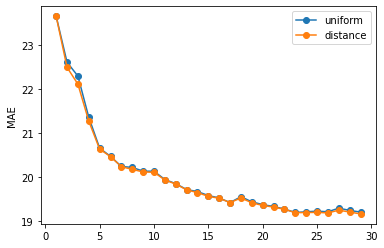

In [ ]:
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_mae = []
       knn = KNeighborsRegressor(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(X_train):
         # Random division of the train set to do cross validation
         f_train_X = X_train.iloc[train_fold]
         f_test_X = X_train.iloc[test_fold]
         f_train_y = y_train.iloc[train_fold]
         f_test_y = y_train.iloc[test_fold]
         # FIT THE MODEL
         f_model = knn.fit(f_train_X, f_train_y)
         # PREDICT AND SCORE
         y_pred = f_model.predict(X = f_test_X)
         mae = mean_absolute_error(f_test_y, y_pred)
         fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show()

The K-nearest-neighbors model give the best performance with the parameter of neighbors with a value of **29** and a **distance** weight

In [ ]:
knn = KNeighborsRegressor(29, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                    weights='distance')

## 2.4 First submission

It is predicted the results with the Gradient Boosting model. This is why it is the model that aparently give a good results and, also, because it is an enssemble model, it could have better performance than a simple linear regression.

In [ ]:
y_pred = boost.predict(X_test[selected_feat_boost])

In [ ]:
y_pred = np.rint(y_pred)
y_pred = y_pred.astype(int)
results = np.hstack(y_pred)

In [ ]:
results

array([  4,   7,  10,   5,   8,  13,  10,  10,  22,  20,  30,  25,  36,
        49,  44,  57,  30,  58,  96,  58,  55,  25,  24,  45,  31,  25,
        28,  26,  27,  27,  23,  13,  18,  19,   9,  18,  16,  19,  15,
        14,  13,  12,  12,  10,   7,   7,   7,   7,   6,   6,   4,   3,
         3,   6,   8,   7,   8,  12,   9,  10,   5,  12,  39,  36,  46,
        46,  46,  45,  42,  45,  47,  30,  51,  58,  69,  62,  59,  47,
        38,  27,  23,  26,  35,  44,  30,  26,  21,  11,  17,  19,  15,
        15,  14,  12,  13,  12,  11,   7,   5,   9,   8,   5,   6,   8,
        10,   7,   9,  14,  10,  26,  48,  38,  43,  29,  51,  57,  61,
        47,  43, 123,  65,  83, 150, 128, 114,  77,  54,  62, 102,  43,
        47,  28,  26,  14,  21,  14,  11,  14,   8,  12,  16,  18,  19,
        16,  18,  13,  13,  12,  11,   9,   6,   7,   7,   5,  10,   6,
         4,   8,   7,   4,   7,  10,  10,  14,  43,  62,  18,  31,  35,
        51,  33,  49,  62,  44,  69,  67,  77,  21,  51,  79,  9

It is imported the original test data without preprocessing to obtain the file to submit.

In [ ]:
original_test = upload_files([])
original_test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [ ]:
output = pd.DataFrame({ 'city': original_test['city'], 'year': original_test['year'], 
                       'weekofyear': original_test['weekofyear'], 'total_cases': results})

with open('submission_baseline.csv', 'w') as f:
  output.to_csv(f,  index = False)

files.download('submission_baseline.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,4
1,sj,2008,19,7
2,sj,2008,20,10
3,sj,2008,21,5
4,sj,2008,22,8
